In [1]:
import torch
from xopt import Xopt
import yaml

YAML = """
xopt:
    dump_file: dump.yaml
generator:
    name: bayesian_exploration
    n_initial: 5
    optim:
        num_restarts: 1
    acq:
        proximal_lengthscales: [1.5, 1.5]

evaluator:
    function: xopt.resources.test_functions.tnk.evaluate_TNK

vocs:
    variables:
        x1: [0, 3.14159]
        x2: [0, 3.14159]
    objectives: {y1: MINIMIZE}
    constraints:
        c1: [GREATER_THAN, 0]
        c2: [LESS_THAN, 0.5]
    constants: {a: dummy_constant}

"""
yaml_output = yaml.safe_load(YAML)

In [2]:
X = Xopt(config=yaml_output)

In [3]:
X.step()

for i in range(5):
    print(f"step {i}")
    X.step()

step 0


/usr/share/miniconda/envs/xopt-dev/lib/python3.9/site-packages/gpytorch/lazy/lazy_tensor.py:1810: UserWarning: torch.triangular_solve is deprecated in favor of torch.linalg.solve_triangularand will be removed in a future PyTorch release.
torch.linalg.solve_triangular has its arguments reversed and does not return a copy of one of the inputs.
X = torch.triangular_solve(B, A).solution
should be replaced with
X = torch.linalg.solve_triangular(A, B). (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1654951030282/work/aten/src/ATen/native/BatchLinearAlgebra.cpp:1666.)
  Linv = torch.triangular_solve(Eye, L, upper=False).solution


step 1
step 2
step 3
step 4


In [4]:
X.data

,x1,x2,a,y1,y2,c1,c2,some_array,xopt_error,xopt_error_str
1,0.331522,1.549698,dummy_constant,0.331522,1.549698,1.608828,1.130250,"[1, 2, 3]",False,
2,0.701325,0.239528,dummy_constant,0.701325,0.239528,-0.503333,0.108377,"[1, 2, 3]",False,
3,2.239570,1.190912,dummy_constant,2.239570,1.190912,5.430517,3.503463,"[1, 2, 3]",False,
4,0.540187,1.317976,dummy_constant,0.540187,1.317976,0.929041,0.670700,"[1, 2, 3]",False,
5,2.786398,0.362039,dummy_constant,2.786398,0.362039,6.942725,5.246650,"[1, 2, 3]",False,
6,2.850448,2.296224,dummy_constant,2.850448,2.296224,12.412206,8.751028,"[1, 2, 3]",False,
7,1.228681,0.743109,dummy_constant,1.228681,0.743109,1.136935,0.590077,"[1, 2, 3]",False,
8,2.654956,0.116699,dummy_constant,2.654956,0.116699,5.986108,4.790755,"[1, 2, 3]",False,
9,0.933802,0.765711,dummy_constant,0.933802,0.765711,0.458957,0.258787,"[1, 2, 3]",False,
10,1.059017,0.345485,dummy_constant,1.059017,0.345485,0.208175,0.336375,"[1, 2, 3]",False,


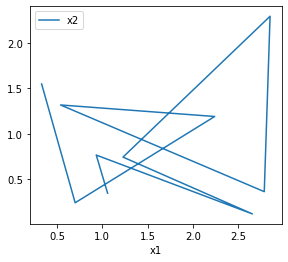

In [5]:
# plot results
ax = X.data.plot("x1", "x2")
ax.set_aspect("equal")

/usr/share/miniconda/envs/xopt-dev/lib/python3.9/site-packages/torch/functional.py:568: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at  /home/conda/feedstock_root/build_artifacts/pytorch-recipe_1654951030282/work/aten/src/ATen/native/TensorShape.cpp:2227.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


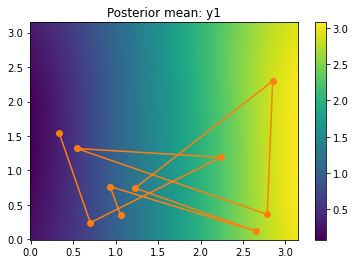

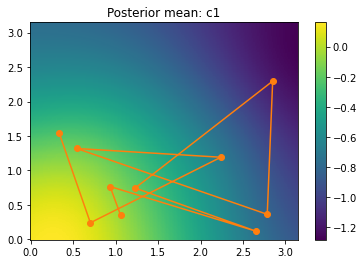

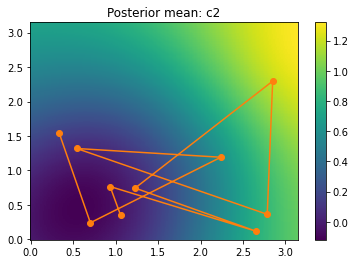

In [6]:
from matplotlib import pyplot as plt  # plot model predictions

data = X.data

bounds = X.generator.vocs.bounds
model = X.generator.model

# create mesh
n = 200
x = torch.linspace(*bounds.T[0], n)
y = torch.linspace(*bounds.T[1], n)
xx, yy = torch.meshgrid(x, y)
pts = torch.hstack([ele.reshape(-1, 1) for ele in (xx, yy)]).double()

outputs = X.generator.vocs.output_names
with torch.no_grad():
    post = model.posterior(pts)

    mean = post.mean
    for i in range(mean.shape[-1]):
        fig, ax = plt.subplots()
        ax.plot(*data[["x1", "x2"]].to_numpy().T, "o-C1")
        c = ax.pcolor(xx, yy, mean[:, i].reshape(n, n))
        fig.colorbar(c)
        ax.set_title(f"Posterior mean: {outputs[i]}")

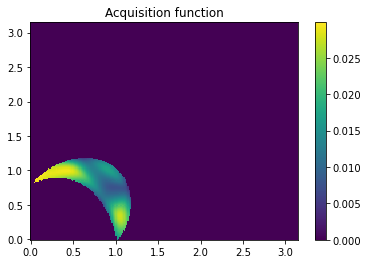

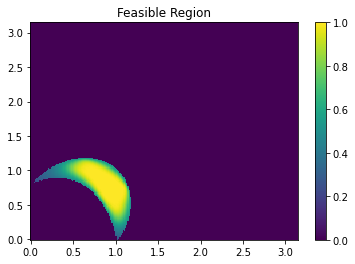

In [7]:
from xopt.generators.bayesian.utils import feasibility

acq_func = X.generator.get_acquisition(model)
with torch.no_grad():
    acq_pts = pts.unsqueeze(1)
    acq = acq_func(acq_pts)

    fig, ax = plt.subplots()
    c = ax.pcolor(xx, yy, acq.reshape(n, n))
    fig.colorbar(c)
    ax.set_title("Acquisition function")

    feas = feasibility(pts.unsqueeze(1), model, X.generator.sampler, X.vocs).flatten()

    fig2, ax2 = plt.subplots()
    c = ax2.pcolor(xx, yy, feas.reshape(n, n))
    fig2.colorbar(c)
    ax2.set_title("Feasible Region")